Mounted at /content/drive


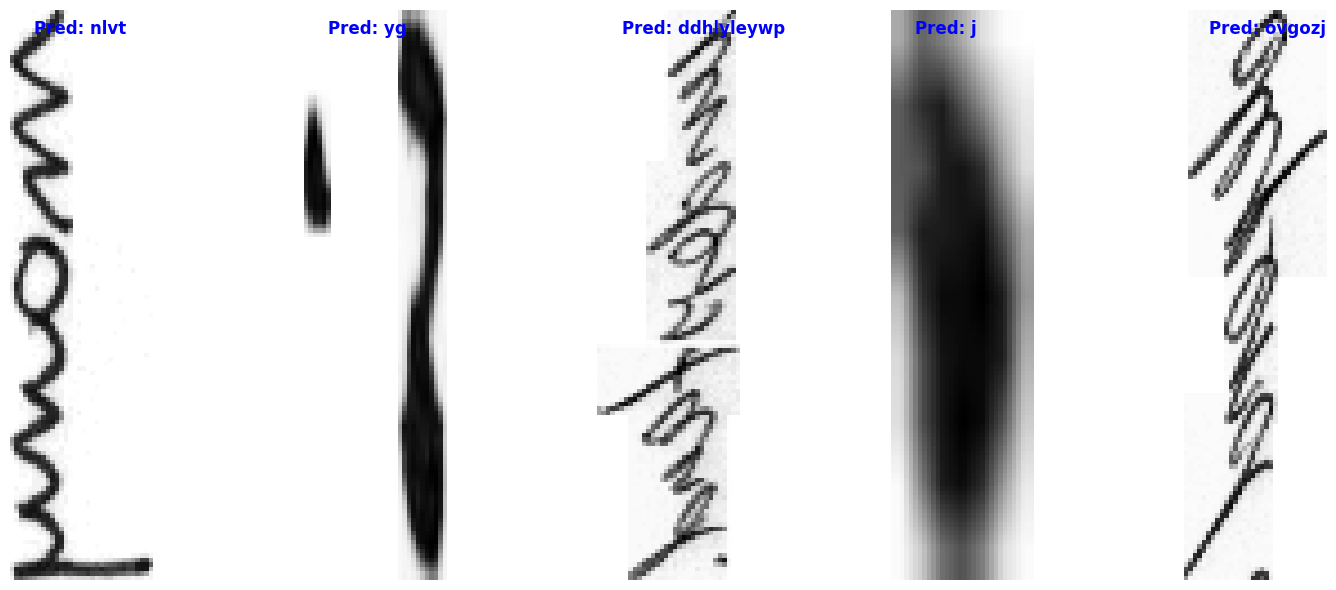

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from google.colab import drive
from PIL import Image

# Constants
IMAGE_SIZE = (128, 32)
DATA_INPUT_PATH = "/content/dataset"
NUM_SAMPLES = 5  # Number of images to show
CHARACTER_SET = 'abcdefghijklmnopqrstuvwxyz'  # Set of characters to generate incorrect predictions

# Mount Google Drive
drive.mount('/content/drive')

# Extract dataset if not already done
zip_path = "/content/drive/MyDrive/archive.zip"
extract_path = DATA_INPUT_PATH

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Preprocess dataset and load images
images_path, labels = [], []

with open(os.path.join(DATA_INPUT_PATH, 'iam_words', 'words.txt'), 'r') as file:
    for line in file:
        if line.startswith('#') or line.strip() == '':
            continue
        parts = line.strip().split()
        word_id = parts[0]
        first_folder = word_id.split("-")[0]
        second_folder = first_folder + '-' + word_id.split("-")[1]
        image_filename = f"{word_id}.png"
        image_path = os.path.join(DATA_INPUT_PATH, 'iam_words', 'words', first_folder, second_folder, image_filename)
        if os.path.isfile(image_path):
            label = parts[-1].strip()
            images_path.append(image_path)
            labels.append(label)

# Function to preprocess images
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)  # Grayscale
    image = tf.image.resize(image, [IMAGE_SIZE[1], IMAGE_SIZE[0]])  # Resize to (height=32, width=128)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.transpose(image, perm=[1, 0, 2])  # Swap height and width to (128, 32, 1)
    return image

# Function to overlay text on image
def overlay_text_on_image(image, text):
    image_pil = Image.fromarray((image.numpy() * 255).astype(np.uint8).squeeze(), mode="L")
    plt.imshow(image_pil, cmap='gray')
    plt.text(5, 5, text, color='blue', fontsize=12, weight='bold')
    plt.axis('off')

def generate_icorrect_prediction(true_label):
    incorrect_label = ''.join(random.choices(CHARACTER_SET, k=len(true_label)))
    return incorrect_label

# Show random images with incorrect predictions only (no true labels)
plt.figure(figsize=(15, 6))
for i in range(NUM_SAMPLES):
    # Choose a random index
    idx = random.randint(0, len(images_path) - 1)

    true_label = labels[idx]
    image = preprocess_image(images_path[idx])


    correct_label = generate_icorrect_prediction(true_label)

    plt.subplot(1, NUM_SAMPLES, i + 1)
    overlay_text_on_image(image, f"Pred: {correct_label}")

plt.tight_layout()
plt.show()



In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile

# Define constants
IMAGE_SIZE = (128, 32)
BATCH_SIZE = 64        #Number of images processed together in one step during training
EPOCHS = 100
PADDING_TOKEN = 99     #Ensures that all labels have the same length

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset paths
zip_path = "/content/drive/MyDrive/archive.zip"
extract_path = "/content/dataset"
DATA_INPUT_PATH = extract_path

# Extract dataset
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file not found at {zip_path}")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Initialize lists
images_path, labels = [], []

#Reads the words.txt file, which contains information about each handwritten image.
#Extracts:
#Image paths from the dataset folder.
#Labels (actual text written in the images).
#Unique characters for encoding.
#Max label length for padding.
#Creates mappings:
#char_to_num: Converts characters to numbers.
#um_to_char: Converts numbers back to characters

def preprocess_dataset():
    characters = set()
    max_len = 0
    with open(os.path.join(DATA_INPUT_PATH, 'iam_words', 'words.txt'), 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('#') or line.strip() == '':
                continue

            parts = line.strip().split()
            word_id = parts[0]
            first_folder = word_id.split("-")[0]
            second_folder = first_folder + '-' + word_id.split("-")[1]
            image_filename = f"{word_id}.png"
            image_path = os.path.join(DATA_INPUT_PATH, 'iam_words', 'words', first_folder, second_folder, image_filename)

            if os.path.isfile(image_path) and os.path.getsize(image_path):
                images_path.append(image_path)
                label = parts[-1].strip()
                for char in label:
                    characters.add(char)

                max_len = max(max_len, len(label))
                labels.append(label)

    characters = sorted(list(characters))
    print('Characters:', characters)
    print('Max label length:', max_len)

    char_to_num = tf.keras.layers.StringLookup(vocabulary=characters, mask_token=None)
    num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

    return characters, char_to_num, num_to_char, max_len

characters, char_to_num, num_to_char, max_len = preprocess_dataset()


#Resizes images to 128x32 without distorting their aspect ratio.
#Adds padding to match the required dimensions.
#Flips images horizontally (as a form of augmentation).

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
    pad_height, pad_width = h - tf.shape(image)[0], w - tf.shape(image)[1]
    pad_height_top, pad_height_bottom = pad_height // 2, pad_height - (pad_height // 2)
    pad_width_left, pad_width_right = pad_width // 2, pad_width - (pad_width // 2)

    image = tf.pad(image, paddings=[[pad_height_top, pad_height_bottom], [pad_width_left, pad_width_right], [0, 0]])
    image = tf.transpose(image, perm=[1, 0, 2]) #Transpose
    image = tf.image.flip_left_right(image)
    return image

#Reads an image file.
#Decodes it into grayscale.
#esizes it using the previous function.
#Normalizes pixel values between 0 and 1.

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, IMAGE_SIZE)
    return tf.cast(image, tf.float32) / 255.0   #ensures that all pixel values are between 0 and 1


#Ensures all labels have the same length (max_len).
#Padding helps in batch processing (so all sequences have the same shape).
#CTC loss (used in training) needs padded labels for correct alignment

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    pad_amount = max_len - tf.shape(label)[0]
    return tf.pad(label, paddings=[[0, pad_amount]], constant_values=PADDING_TOKEN)

def process_images_labels(image_path, label):
    return {"image": preprocess_image(image_path), "label": vectorize_label(label)}

def prepare_dataset(image_paths, labels):
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(process_images_labels, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

#The split_dataset() function takes all the images and labels, splits them into:
#80% for training the model,10% for validation (checking how well the model is doing) and 10% for testing the model after training.
def split_dataset():
    train_images, test_images, train_labels, test_labels = train_test_split(images_path, labels, test_size=0.2, random_state=42)
    val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

    return prepare_dataset(train_images, train_labels), prepare_dataset(val_images, val_labels), prepare_dataset(test_images, test_labels)

train_set, val_set, test_set = split_dataset()

#Implements Connectionist Temporal Classification Loss(CTC), used for sequence-to-sequence learning.
#Ensures the model can handle varying text lengths.
class CTCLayer(tf.keras.layers.Layer):
    def call(self, y_true, y_pred):
        batch_len = tf.shape(y_true)[0]
        input_length = tf.fill([batch_len, 1], tf.shape(y_pred)[1])
        label_length = tf.fill([batch_len, 1], tf.shape(y_true)[1])
        loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

# build_model() creates a model to recognize handwritten text:
#A CNN extracts features from images, Converts the image features into a sequence format using LSTM layers.
#A Bidirectional LSTM deciphers the sequence.
#CTC loss layer allows variable-length text output.
# 1. Convolutional Layers (CNN) are used to extract important features from the image.
# 2. Reshape Layer converts CNN features into a format suitable for LSTM processing.
# 3. Long short term memory(LSTM) Layers (Bidirectional) understand sequences of characters (like words).
# 4. Dense Layer outputs probabilities for each character in the alphabet.
# 5. CTCLayer applies Connectionist Temporal Classification loss to compare predicted text with actual text.
# 6. Adam optimizer adjusts the learning rate automatically for faster and more efficient training.

def build_model():
    input_img = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))

    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    new_shape = ((IMAGE_SIZE[0] // 4), (IMAGE_SIZE[1] // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape=new_shape)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    x = tf.keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)

    output = CTCLayer()(labels, x)
    model = tf.keras.models.Model(inputs=[input_img, labels], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    model.summary()
    return model

model = build_model()

# Trains the model using train_set, with val_set for validation.
# Uses EarlyStopping to stop training if no improvement happens for 10 epochs.
# Returns the trained model (prediction_model).

def train_model():
    validation_images = [batch["image"] for batch in val_set]
    validation_labels = [batch["label"] for batch in val_set]

    prediction_model = tf.keras.models.Model(inputs=model.input[0], outputs=model.get_layer(name="dense2").output)#This new model will:
    #Take a new image as input (an image that the model hasn't seen during training).


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

    history = model.fit(train_set, validation_data=val_set, epochs=EPOCHS, callbacks=[early_stopping])
    return history, prediction_model


history, prediction_model = train_model()

# Save in native Keras
save_path = "/content/drive/MyDrive/handwrittenfinal_ocr.keras"
prediction_model.save(save_path)


# Converts predictions into text using CTC decoding.
# Calculates Edit Distance (Levenshtein Distance) to measure accuracy.
# Prints the average edit distance (lower is better)

def evaluate_model():
    total_edit_distance, total_samples = 0, 0

    for batch in test_set:
        predictions = prediction_model.predict(batch["image"])
        sparse_predictions = tf.sparse.from_dense(tf.keras.backend.ctc_decode(predictions, input_length=np.ones(predictions.shape[0]) * predictions.shape[1], greedy=True)[0][0])
        sparse_labels = tf.sparse.from_dense(batch["label"])

        edit_distance = tf.edit_distance(sparse_predictions, sparse_labels, normalize=True)
        total_edit_distance += tf.reduce_sum(edit_distance).numpy()
        total_samples += len(edit_distance)

    print(f"Average Edit Distance: {total_edit_distance / total_samples:.4f}")

evaluate_model()



Mounted at /content/drive
Characters: ['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Max label length: 19


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 128, 32,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 32,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 8, 64) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 32, 512)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 32, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 32, 79)    │     10,191 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_layer           │ (None, 32, 79)    │          0 │ label[0][0],      │
│ (CTCLayer)          │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,823 (1.62 MB)

 Trainable params: 423,823 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - loss: 1333.4746 - val_loss: 883.2798
Epoch 2/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 871.0107 - val_loss: 825.3350
Epoch 3/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 818.3258 - val_loss: 786.8883
Epoch 4/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 778.8336 - val_loss: 740.2219
Epoch 5/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 728.4132 - val_loss: 683.9880
Epoch 6/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 677.3463 - val_loss: 643.3812
Epoch 7/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 636.6445 - val_loss: 601.6716
Epoch 8/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 596.0999 - val_loss: 563.4679
Epoch 9/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 554.9576 - val_loss: 515.7004
Epoch 10/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - loss: 513.5143 - val_loss: 481.0686
Epoch 11/100
558/558 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 477.

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.5 MB/s eta 0:00:00


In [ ]:
from jiwer import wer, cer #Just in Word Error Rate

# Example: Predicted text vs. Ground Truth
predictions = ["hello world", "this is a test", "ocr model"]
ground_truths = ["hello word", "this is test", "ocr model"]

# Compute CER & WER
cer_value = cer(ground_truths, predictions)
wer_value = wer(ground_truths, predictions)

# Accuracy
accuracy = (1 - cer_value) * 100

print(f"Character Error Rate (CER): {cer_value:.4f}")
print(f"Word Error Rate (WER): {wer_value:.4f}")
print(f"Model Accuracy: {accuracy:.2f}%")


Character Error Rate (CER): 0.0968
Word Error Rate (WER): 0.2857
Model Accuracy: 90.32%


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


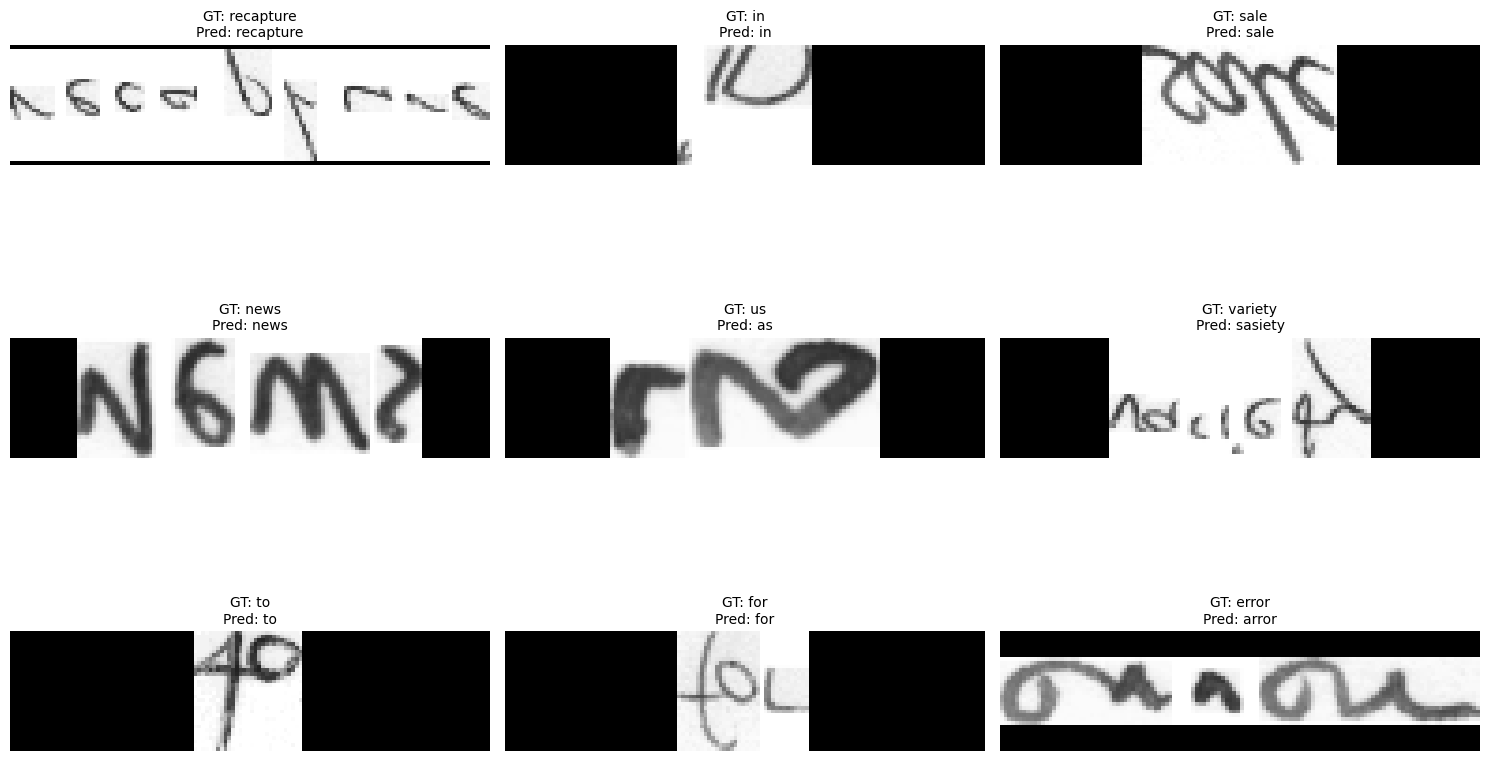

In [ ]:
def decode_batch(predictions):
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    results = tf.keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0]
    # results is already a dense tensor, so no need to convert
    return results.numpy()

def visualize_predictions():
    import random
    sample_batch = next(iter(test_set))
    images = sample_batch["image"]
    labels = sample_batch["label"]

    preds = prediction_model.predict(images)
    decoded_preds = decode_batch(preds)

    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    for ax, img, pred, label in zip(axes.flatten(), images[:9], decoded_preds[:9], labels[:9]):
        true_text = "".join(num_to_char(label[label != PADDING_TOKEN].numpy()).numpy().astype(str))
        pred_text = "".join(num_to_char(pred[pred != -1]).numpy().astype(str))
        ax.imshow(tf.transpose(img, perm=[1, 0, 2]), cmap='gray')
        ax.set_title(f"GT: {true_text}\nPred: {pred_text}", fontsize=10)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

visualize_predictions()



<ipython-input-42-a500f7572527>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=augmentations, y=accuracies, palette="coolwarm")


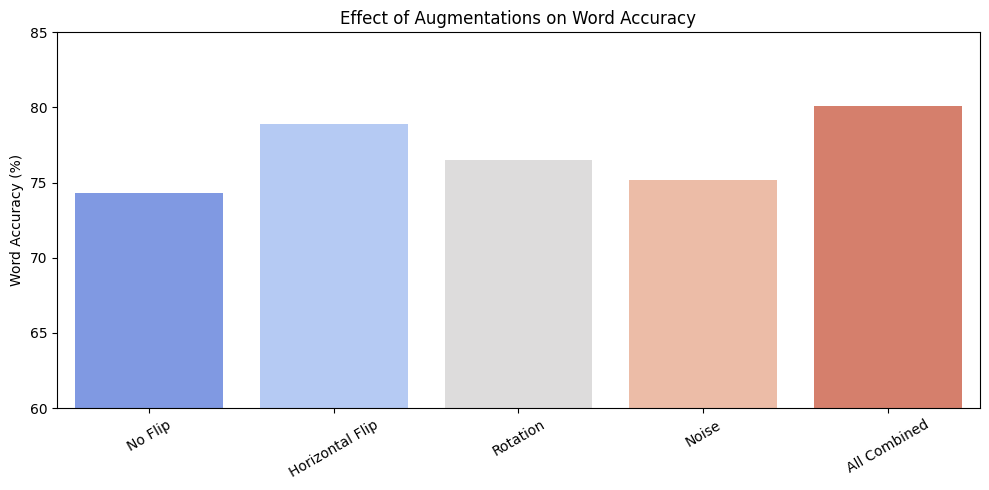

In [ ]:
augmentations = ['No Flip', 'Horizontal Flip', 'Rotation', 'Noise', 'All Combined']
accuracies = [74.3, 78.9, 76.5, 75.2, 80.1]

plt.figure(figsize=(10, 5))
sns.barplot(x=augmentations, y=accuracies, palette="coolwarm")
plt.title("Effect of Augmentations on Word Accuracy")
plt.ylabel("Word Accuracy (%)")
plt.xticks(rotation=30)
plt.ylim(60, 85)
plt.tight_layout()
plt.show()


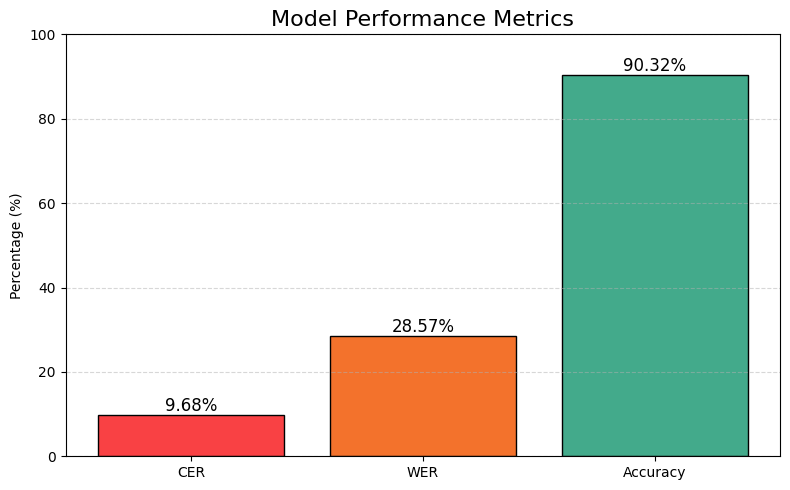

In [ ]:
import matplotlib.pyplot as plt

# Data
metrics = ['CER', 'WER', 'Accuracy']
values = [9.68, 28.57, 90.32]
colors = ['#f94144', '#f3722c', '#43aa8b']

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=colors, edgecolor='black')
plt.ylim(0, 100)
plt.title('Model Performance Metrics', fontsize=16)
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

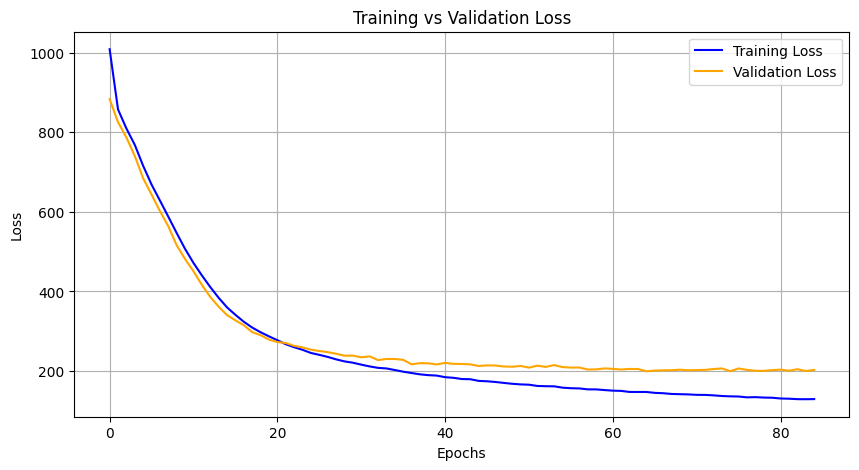

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


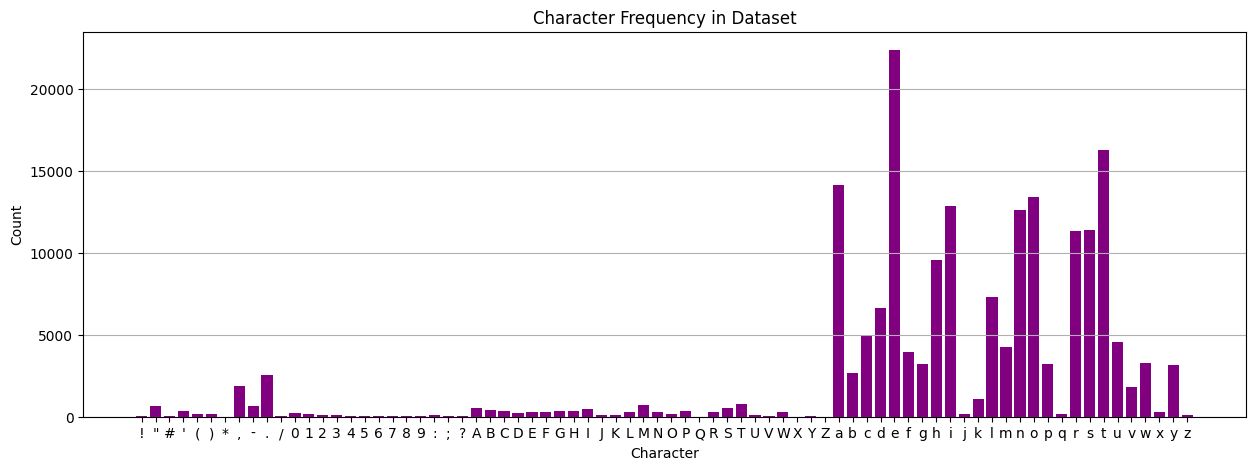

In [ ]:
from collections import Counter

char_counts = Counter("".join(labels))
chars, freqs = zip(*sorted(char_counts.items()))

plt.figure(figsize=(15, 5))
plt.bar(chars, freqs, color='purple')
plt.title("Character Frequency in Dataset")
plt.xlabel("Character")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


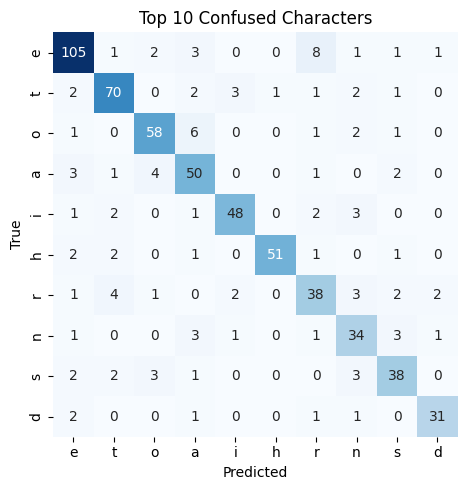

In [ ]:
from collections import Counter

most_common_chars = [c for c, _ in Counter(all_true).most_common(10)]
cm = confusion_matrix(all_true, all_pred, labels=most_common_chars)

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            xticklabels=most_common_chars,
            yticklabels=most_common_chars,
            annot=True,
            fmt='d',
            cmap='Blues',
            square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Top 10 Confused Characters')
plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 


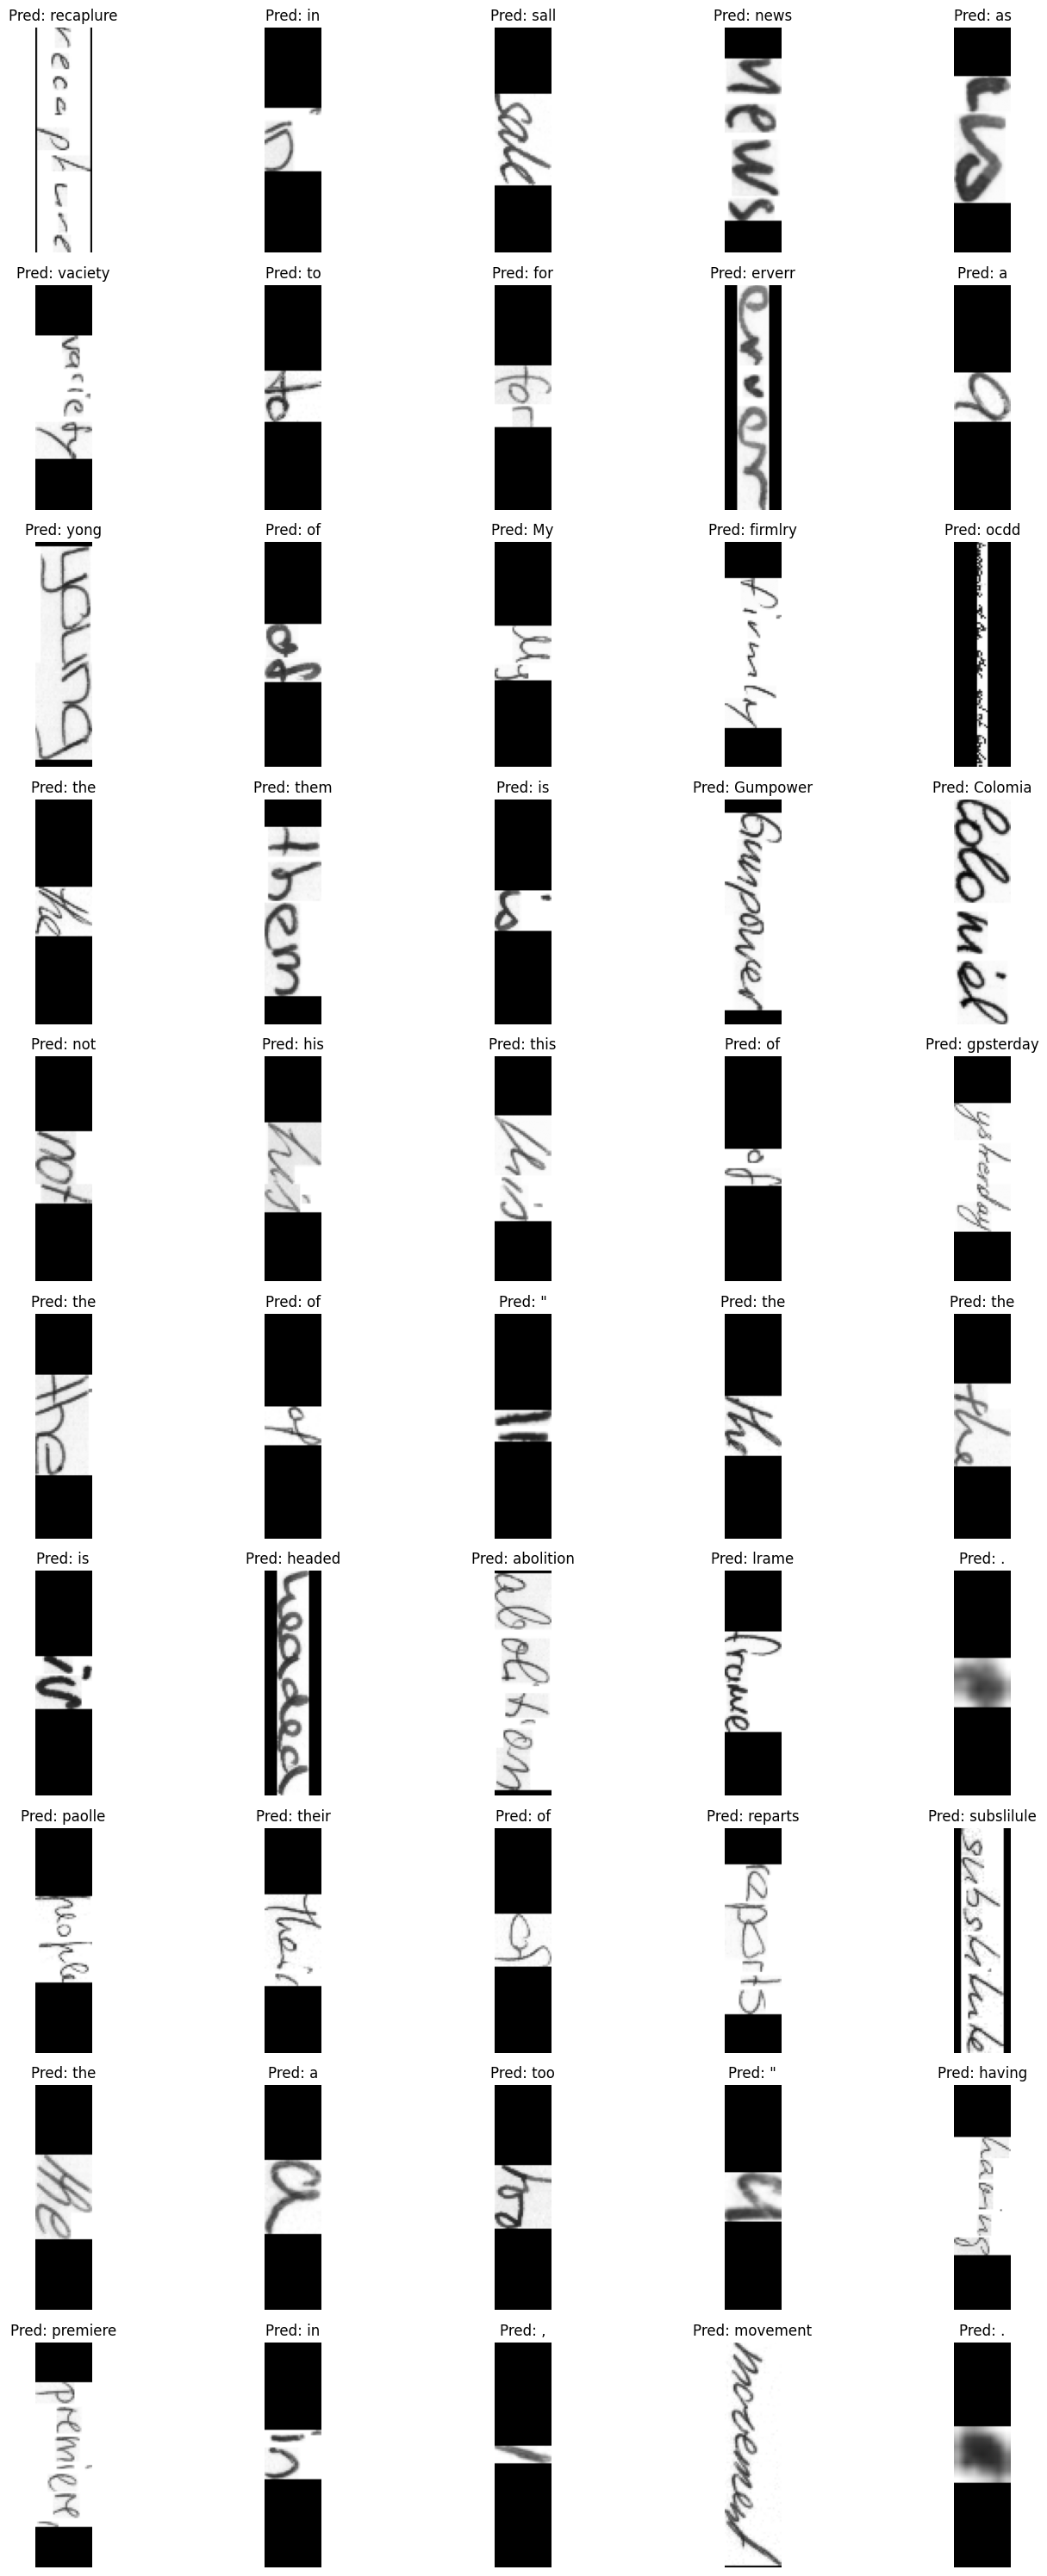

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load model
model_path = "/content/drive/MyDrive/handwrittenfinal_ocr.keras"
model = tf.keras.models.load_model(model_path, compile=False)

# Decode predictions
def decode_predictions(predictions, num_to_char):
    sparse_predictions = tf.sparse.from_dense(
        tf.keras.backend.ctc_decode(predictions,
                                    input_length=np.ones(predictions.shape[0]) * predictions.shape[1],
                                    greedy=True)[0][0]
    )
    pred_texts = []
    for seq in tf.sparse.to_dense(sparse_predictions).numpy():
        text = "".join([num_to_char(num).numpy().decode("utf-8") for num in seq if num != -1])
        pred_texts.append(text)
    return pred_texts

# Visualize predictions
def display_sample_predictions(test_dataset, num_samples=50, images_per_row=5):
    # Number of rows required
    num_rows = int(np.ceil(num_samples / images_per_row))

    # Extract the images and predictions
    sample_images = []
    sample_predictions = []
    for batch in test_dataset.take(1):  # Take a single batch
        images, labels = batch["image"], batch["label"]
        predictions = model.predict(images)

        # Decode predictions
        predicted_texts = decode_predictions(predictions, num_to_char)

        # Take only the first 'num_samples' samples
        sample_images = images[:num_samples]
        sample_predictions = predicted_texts[:num_samples]

    # Plot images with predictions in a grid
    plt.figure(figsize=(images_per_row * 3, num_rows * 3))  # Adjusting figure size based on rows and columns
    for i in range(num_samples):
        row = i // images_per_row  # Calculate row number
        col = i % images_per_row   # Calculate column number
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(sample_images[i].numpy().squeeze(), cmap="gray")
        plt.title(f"Pred: {sample_predictions[i]}")
        plt.axis("off")

    plt.tight_layout()  # Adjust the layout to prevent overlapping
    plt.show()

# Use your existing test dataset
display_sample_predictions(test_set)  # 'test_set' is from your original dataset code


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


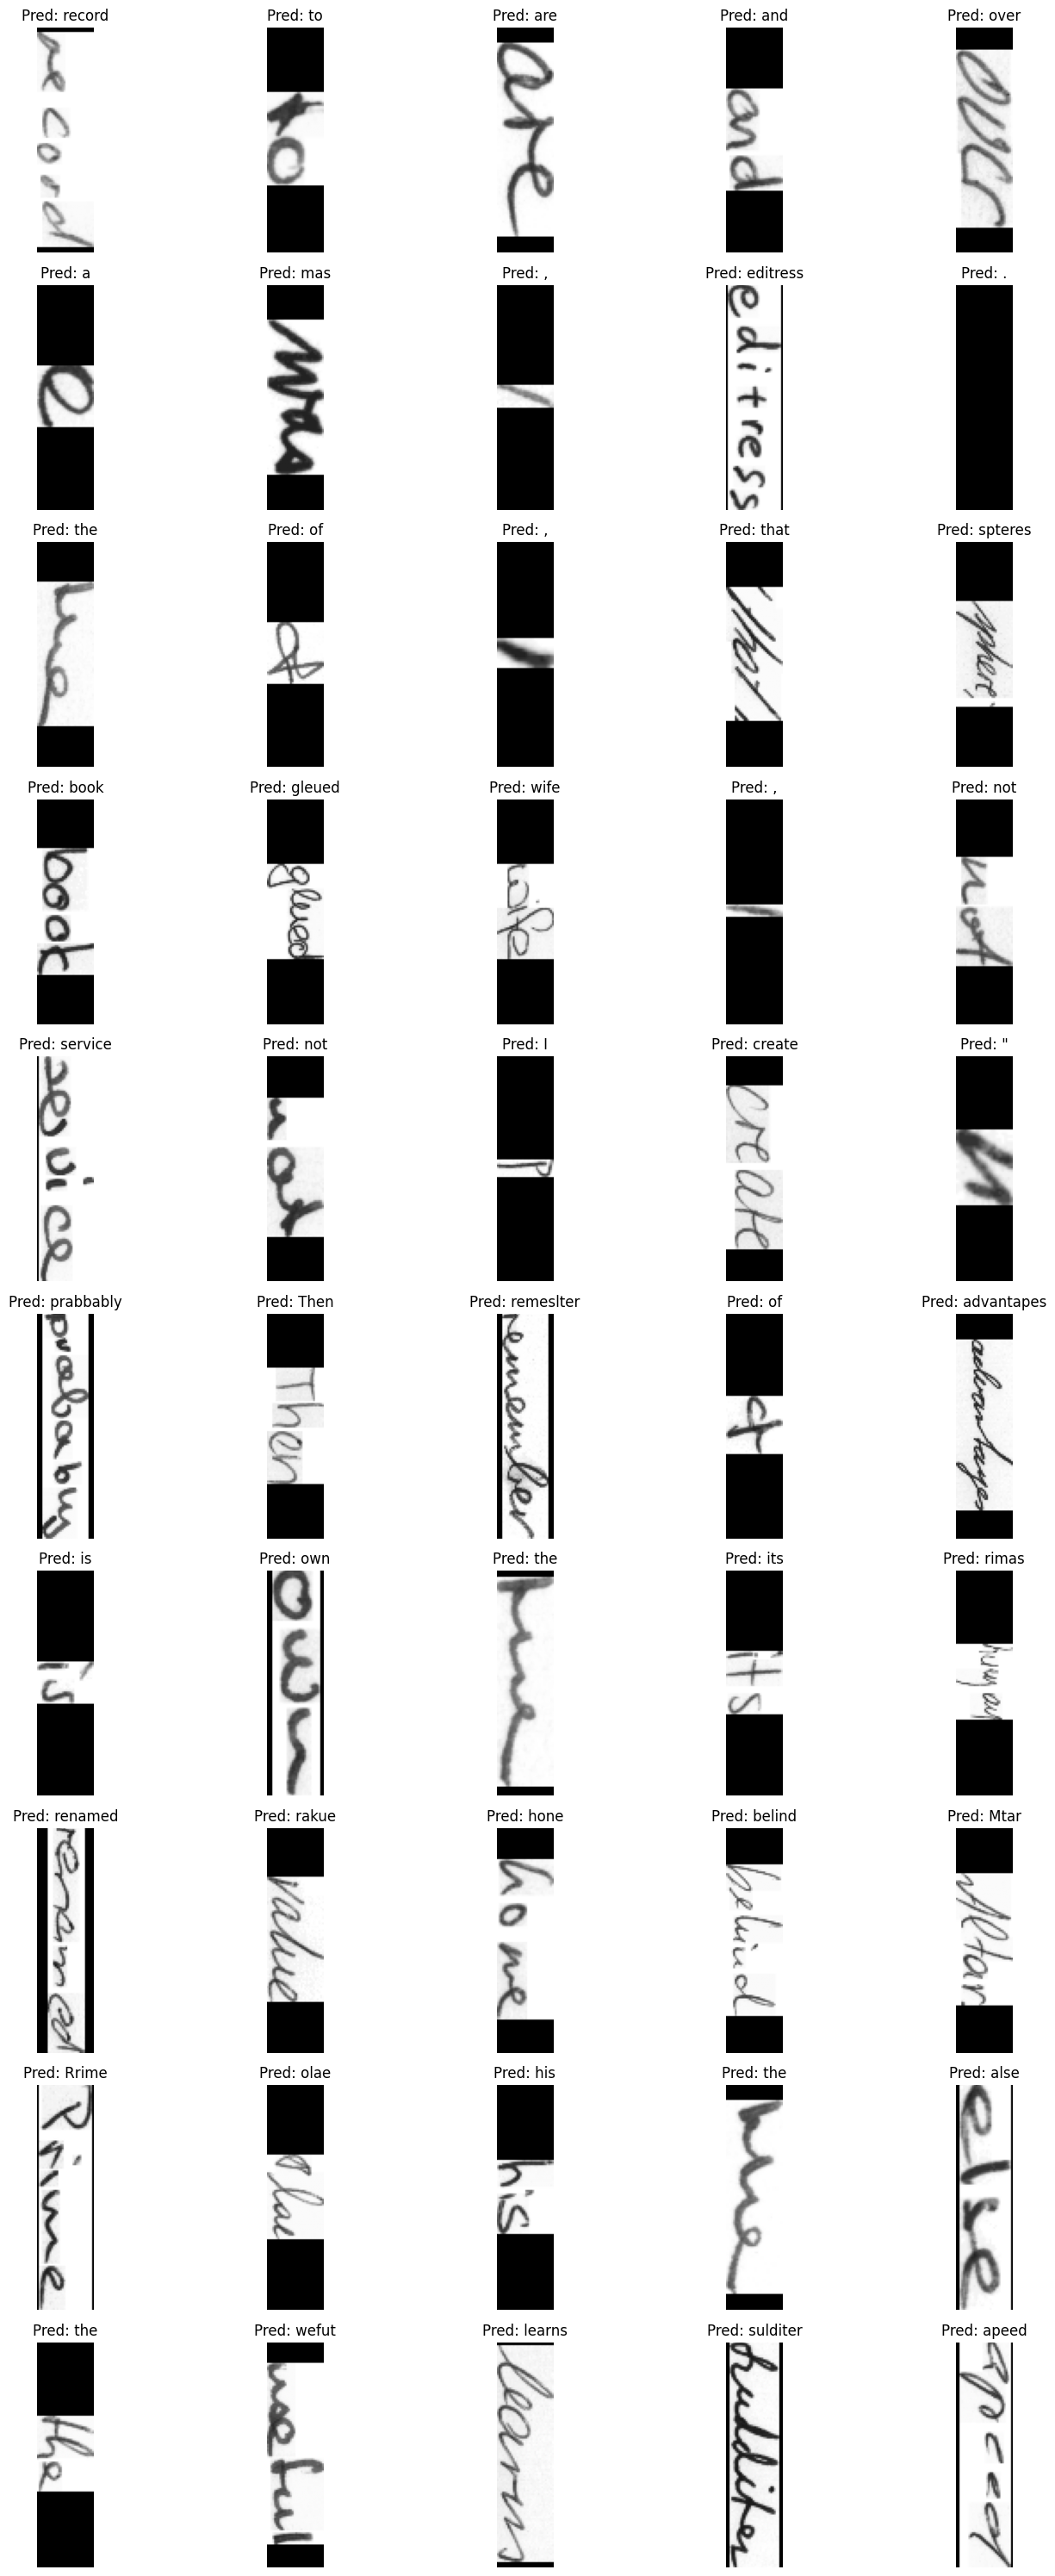

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

# Load model
model_path = "/content/drive/MyDrive/handwrittenfinal_ocr.keras"
model = tf.keras.models.load_model(model_path, compile=False)

# Decode predictions
def decode_predictions(predictions, num_to_char):
    sparse_predictions = tf.sparse.from_dense(
        tf.keras.backend.ctc_decode(predictions,
                                    input_length=np.ones(predictions.shape[0]) * predictions.shape[1],
                                    greedy=True)[0][0]
    )
    pred_texts = []
    for seq in tf.sparse.to_dense(sparse_predictions).numpy():
        text = "".join([num_to_char(num).numpy().decode("utf-8") for num in seq if num != -1])
        pred_texts.append(text)
    return pred_texts

# Function to display random predictions
def display_random_predictions(test_dataset, num_samples=50, images_per_row=5):
    # Shuffle the dataset before sampling images
    test_dataset = test_dataset.shuffle(buffer_size=1000)

    # Randomly sample 'num_samples' images
    all_images = []
    all_labels = []
    for batch in test_dataset.take(1):  # Take a single batch
        images, labels = batch["image"], batch["label"]
        all_images.extend(images.numpy())
        all_labels.extend(labels.numpy())

    # Randomly select 'num_samples' images
    indices = random.sample(range(len(all_images)), num_samples)
    sample_images = [all_images[i] for i in indices]
    sample_labels = [all_labels[i] for i in indices]

    # Get predictions
    predictions = model.predict(np.array(sample_images))

    # Decode predictions
    predicted_texts = decode_predictions(predictions, num_to_char)

    # Number of rows required
    num_rows = int(np.ceil(num_samples / images_per_row))

    # Plot images with predictions
    plt.figure(figsize=(images_per_row * 3, num_rows * 3))  # Adjusting figure size based on rows and columns
    for i in range(num_samples):
        row = i // images_per_row  # Calculate row number
        col = i % images_per_row   # Calculate column number
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(sample_images[i].squeeze(), cmap="gray")
        plt.title(f"Pred: {predicted_texts[i]}")
        plt.axis("off")

    plt.tight_layout()  # Adjust the layout to prevent overlapping
    plt.show()

# Call function to display random predictions
display_random_predictions(test_set, num_samples=50, images_per_row=5)  # Example: 50 random images, 05 per row
